# Learning Nim with Temporal Difference
This Notebook contains the main code to make an agent learn how to play Nim with Temporal Difference learning. The algorithm used is Q-learning.
To run a code-block, click inside and the click "Ctrl"+"enter".
The output of each block is situated just after this one.

## 1 - Initialization
In this part we initialize the variables and function needed.
Under "Variables initialization", the different parameters can be modified. "board_ini" is the biggest board that will be learned: it represents the dimensionality of the state space.

In [1]:
# import general librairies
from time import sleep
import random as rnd
import matplotlib.pyplot as plt
from IPython.display import clear_output
# personal librairies
from SA import SA
from AgentQ import AgentQ
from Opponent import Opponent

# Variables initialization
##################################################
# Reinforcement learning
discount = 1 # no discounting (=gamma) (Keep at 1)
stepSize = 1 # alpha , the learning rate
epsilon = 1 # for the epsilon-greedy policy
opp_epsilon = 0. # fraction of randomness for the opponent of the learning phase
# Nim
board_ini = sorted([5,5,5,5]) # Biggest board for learning Nim (bigger board won't be learned)
runMax = int(3E4) # Number of runs for the learning
##################################################

# Function initialization
def init_board():
    """
    Return a random board based on board_ini
    """
    for i in range(len(board_ini)):
        board[i] = rnd.randint(0,board_ini[i])
    board.sort()
    
    if board[-1] == 0:
        return init_board()
    return board

## 2 - Reinforcement Learning
This is in this section that the agent will actually learn. "runMax" (above) contains the number of runs for the learning (an output is displayed at the bottom to help keep track of the current run).
Nothing can be modified here.

In [2]:
# Board and agent
board = list(board_ini)
board_end = [0] * len(board_ini)
agent = AgentQ(SA(board), stepSize, discount, epsilon)
oppLearning = Opponent(SA(board), policy="e-optimal", epsilon=opp_epsilon)
oppOptimal = Opponent(SA(board), policy="optimal")

# Learning curves lists
learning_win = []
greedy_win = []
optimalMoves = []
optimalMoves_runNb = []
optMoveFound_Recall = []
optMoveFound_Precision = []
optMoveFound_F = []
optMoveFound_runNb = []

# Actual learning
for run in range(runMax):
    if (run+1) % 1000 == 0:
        clear_output()
        print("run   : {0}/{1}\n".format(run+1, runMax))
    
    board = init_board()
    
    # randomly choose the first player
    agentIsFirst = rnd.randint(0,1)
    if agentIsFirst == False:
        oppLearning.move(board)
        if board == board_end:
            learning_win.append(-1)
            continue
    
    # move until the end of the current game
    while True:
        agent.move(board)
        if board == board_end:
            agent.winUpdate()
            learning_win.append(1)
            break
        
        oppLearning.move(board)
        if board == board_end:
            agent.loseUpdate()
            learning_win.append(-1)
            break
            
        agent.updateQ(board)
    
    ## Test the agent every 100 runs on 100 more runs
    # Here, the agent uses a greedy policy
    if (run+1) % 100 == 0:
        optMovePossible = 0.
        optMoveMade = 0.
        wins = 0.
        for _ in range(100):
            
            ## The agent should always start in a winning position
            # or it will necessarily lose against an optimal opponent
            board = init_board()
            before = 0
            for i in range(len(board)):
                before ^= board[i]
            while before == 0:
                board = init_board()
                before = 0
                for i in range(len(board)):
                    before ^= board[i]
            
            while True:
                before = 0
                for i in range(len(board)):
                    before ^= board[i]
                if before != 0:
                    optMovePossible += 1
                    
                agent.greedyMove(board)
               
                after = 0
                for i in range(len(board)):
                    after ^= board[i]
                if after == 0:
                    optMoveMade += 1
                
                if board == board_end:
                    wins += 1.
                    break
                
                oppOptimal.move(board)
                if board == board_end:
                    wins += 0.
                    break
        
        greedy_win.append(wins)
        optimalMoves.append(optMoveMade/optMovePossible*100)
        optimalMoves_runNb.append(run)
        
        ## Compute current F-Score
        # For each possible actions see if it's optimal and check if the agent
        # considers it as optimal or not
        optMove_P = 0. # Positives (optimal moves)
        optMove_TP = 0. # True-positives (optimal moves seen as optimal)
        optMove_FP = 0. # False-positives (non-optimal moves seen as optimal)
        for s in agent.states:
            board = list(agent.states[s])
            for heap in range(len(board)):
                for action in range(1,1+board[heap]):
                    temp_board = list(board)
                    temp_board[heap] -= action
                              
                    nimSum = 0
                    for i in range(len(temp_board)):
                        nimSum ^= temp_board[i]
                    
                    
                    a = agent.actions.index([heap,action])
                    if nimSum == 0:
                        optMove_P += 1.
                        if agent.Q[s][a] >= 0.9:
                            optMove_TP += 1.
                    elif agent.Q[s][a] >= 0.9:
                        optMove_FP += 1.
        
        optMoveFound_Recall.append(optMove_TP/optMove_P)
        if optMove_TP+optMove_FP == 0:
            optMoveFound_Precision.append(0.)
        else:
            optMoveFound_Precision.append(optMove_TP/(optMove_TP+optMove_FP))
        if optMoveFound_Precision[-1]+optMoveFound_Recall[-1] == 0:
            optMoveFound_F.append(0.)
        else:
            optMoveFound_F.append(2*optMoveFound_Precision[-1]*optMoveFound_Recall[-1] / \
                              (optMoveFound_Precision[-1]+optMoveFound_Recall[-1]))
        optMoveFound_runNb.append(run)

run   : 30000/30000



## 3 - Learning curves
In this section we plot the different curves used to evaluate the learning of the agent.
Here again, nothing can be modified.

### 3.1 Learning curve
We plot here the basic learning curve, that is the reward that the agent is able to get through the learning runs.

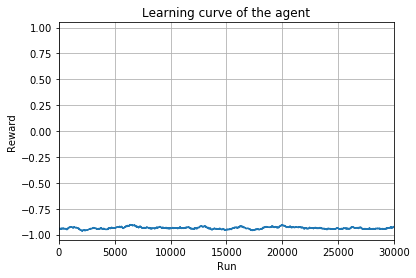

In [3]:
# Window averaging of the learning curve
half_window = 500
learning_win_ave = []

for i in range(len(learning_win)):
    startIndex = i - half_window
    if startIndex < 0:
        startIndex = 0
        
    endIndex = i + half_window + 1
    if endIndex > len(learning_win):
        endIndex = len(learning_win)
    
    learning_win_ave.append(float(sum(learning_win[startIndex:endIndex])) / (len(learning_win[startIndex:endIndex])))
# Learning curve
plt.plot(learning_win_ave)
plt.title("Learning curve of the agent")
plt.xlabel("Run"); plt.ylabel("Reward")
plt.axis([0, runMax, -1.05, 1.05]); plt.grid(True)
plt.show()

However, the previous learning curve is actually not really helpful to assess the quality of the agent. Indeed, depending on the set of parameters, the exploration and optimality of the opponent might cause the agent to lose most of the time, even though it learns. That is why we will introduce the few next measures.

### 3.2 - Winning rate
The first way of estimating the agent is to look at its percentage of win against an optimal opponent. To do so, we won't use the learning runs because the agent loses most of the times. Instead, every 100 runs in the learning we perform another 100 runs, but this time the agent acts greedily.

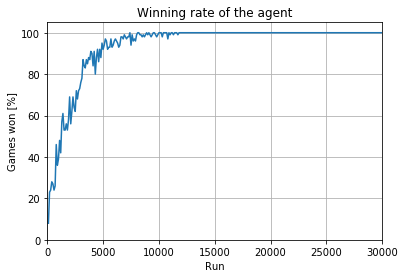

In [4]:
# Winning rate (after greedization)
plt.plot(optimalMoves_runNb, greedy_win)
plt.title("Winning rate of the agent")
plt.xlabel("Run"); plt.ylabel("Games won [%]")
plt.axis([0, runMax, 0, 105]); plt.grid(True)
plt.show()

### 3.3 - Optimal moves rate
We know that in order to win, the agent has to act optimally all the time (if it is not already in a losing position). Then, one mistake makes him lose the game against an optimal opponent. That means that, even though it might have done good 90% of the time, it can still lose. Therefore, another way to evaluate the agent would be to see how many times it performs optimally when it can. Using the same "greedy runs" as in 3.2, we plot the rate of optimal moves effectuated.

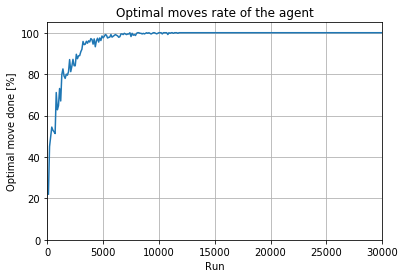

In [5]:
# Optimal moves rate (after greedization)
plt.plot(optimalMoves_runNb, optimalMoves)
plt.title("Optimal moves rate of the agent")
plt.xlabel("Run"); plt.ylabel("Optimal move done [%]")
plt.axis([0, runMax, 0, 105]); plt.grid(True)
plt.show() 

### 3.4 - F-Measure
Finally, to go even further we might want to see if the agent has been able to identify every possible optimal moves, while rejecting all the others. To do so, we can think of this as a classification problem: the agent has to classify every optimal moves from the others. We can then use the F-measure to evaluate this. As the action-values are only estimations, to see if the agent considers a move as optimal, we simply compare its Q(s,a) value to a threshold (close to the actual value of an optimal move). This will be used in the grid search as the evaluation criterion.

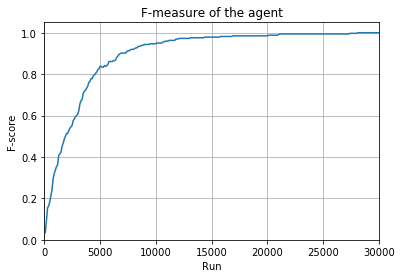

In [7]:
# F-measure (after greedization)
plt.plot(optMoveFound_runNb, optMoveFound_F)
plt.title("F-measure of the agent")
plt.xlabel("Run"); plt.ylabel("F-score")
plt.axis([0, runMax, 0, 1.05]); plt.grid(True)
plt.show()   

## 4 - Test of the agent after learning
Now we will test the agent against an optimal opponent. We compute the winning and optimal move rates, and compute the final value of the F-Score. The number of games can be changed below, by modifing "trials".

In [8]:
##################################################
trials = 2000 # number of trials for testing
##################################################
wins = 0
winStart = 0
optMove = 0
optDone = 0
# Compete the agent against the optimal opponent
for i in range(trials):
    board = init_board()
        
    agentIsFirst = rnd.randint(0,1)
    if agentIsFirst == False:
        oppOptimal.move(board)
        if board == board_end:
            continue
    
    # See if the agent should be able to win
    before = 0
    for i in range(len(board)):
        before ^= board[i]
    if before != 0:
        winStart += 1
    while True:
        # See if an optimal move is available
        before = 0
        for i in range(len(board)):
            before ^= board[i]
        if before != 0:
            optMove += 1
            
        agent.greedyMove(board)
       
        after = 0
        for i in range(len(board)):
            after ^= board[i]
        if after == 0:
            optDone += 1
        
        if board == board_end:
            wins += 1
            break
        
        oppOptimal.move(board)
        if board == board_end:
            break

print "Agent tested over {} games:\n".format(trials)
print "Winning rate (only considering games where the agent can win):\n" + \
       "{}/{} = {:.2f}%\n".format(wins, winStart, float(wins)/float(winStart)*100)
print "Optimal moves rate (only considering moves where an optimal one exists):\n" + \
       "{}/{} = {:.2f}%\n".format(optDone, optMove, float(optDone)/float(optMove)*100)

## Compute the final F-Score
# For each possible actions see if it's optimal and check if the agent
# considers it as optimal or not
optMove_P = 0. # Positives (optimal moves)
optMove_TP = 0. # True-positives (optimal moves seen as optimal)
optMove_FP = 0. # False-positives (non-optimal moves seen as optimal)
for s in agent.states:
    board = list(agent.states[s])
    for heap in range(len(board)):
        for action in range(1,1+board[heap]):
            temp_board = list(board)
            temp_board[heap] -= action
                      
            nimSum = 0
            for i in range(len(temp_board)):
                nimSum ^= temp_board[i]
            
            
            a = agent.actions.index([heap,action])
            if nimSum == 0:
                optMove_P += 1.
                if agent.Q[s][a] >= 0.9:
                    optMove_TP += 1.
            elif agent.Q[s][a] >= 0.9:
                optMove_FP += 1.

optMoveFound_Recall = optMove_TP/optMove_P
if optMove_TP+optMove_FP == 0.:
    optMoveFound_Precision = 0.
else:
    optMoveFound_Precision = optMove_TP/(optMove_TP+optMove_FP)
if optMoveFound_Precision+optMoveFound_Recall == 0:
    optMoveFound_F = 0.
else:
    optMoveFound_F = 2*optMoveFound_Precision*optMoveFound_Recall / \
                      (optMoveFound_Precision+optMoveFound_Recall)
        
print "Recall = {:.3f}".format(optMoveFound_Recall)
print "Precision = {:.3f}".format(optMoveFound_Precision)
print "---"
print "F-Score = {:.3f}".format(optMoveFound_F)

Agent tested over 2000 games:

Winning rate (only considering games where the agent can win):
993/993 = 100.00%

Optimal moves rate (only considering moves where an optimal one exists):
3315/3315 = 100.00%

Recall = 1.000
Precision = 1.000
---
F-Score = 1.000


## 5 - Play against the agent
In this last section we propose you to play against the agent that has just learned. Simply run the code, and the game is going to happen in the output.

In [ ]:
clear_output()
wantToPlay = True

while wantToPlay:
    print "--------------\nNim - New game\n--------------\n"
    
    print "Let's start by defining our game:"
    print "There are {} heaps,".format(len(board_ini)) + \
    " but you might have some of them empty (for instance if you want to play with less)."
    
    # Create the board
    board = []
    for x in range(len(board_ini)):
        num = raw_input("Enter number of matches on heap {}: (must be between 0 and {})\n".format(x+1, board_ini[x]))
        num = int(num)
        while num < 0 or num > 5:
            clear_output()
            print "Wrong number of matches!"
            num = raw_input("Enter number of matches on heap {}: (must be between 0 and {})\n".format(x+1, board_ini[x]))
            num=int(num)
        board.append(num)
    while len(board) < len(board_ini):
        board.append(0)
    
    if board == board_end:
        clear_output()
        print "The board cannot be empty! Let's restart..."
        sleep(1.3)
        continue
    
    clear_output()
    print "Note that the board will be sorted after each move."
    print "Current board: {}\n".format(board)
    board.sort()
    print "Sorted board: {}\n".format(board)
    
    userStart = raw_input("Do you want to start? (y/n)\n")
    
    if userStart.startswith('n') or userStart.startswith('N'):
        clear_output()
        print "Current board: {}\n".format(board)
        sleep(1)
        print "The agent moves..."
        sleep(1.5)
        agent.greedyMove(board)
        clear_output()
        print "Current board: {}\n".format(board)
        if board == board_end:
            print "You lost..."
            wantToPlay = raw_input("Do you want to play again? (y/n)")
            if wantToPlay.startswith('y') or userStart.startswith('Y'):
                wantToPlay = True
            else:
                wantToPlay = False
            continue
    else:
        clear_output()
        print "Current board: {}\n".format(board)
    
    # Moves until the end of the game
    while True:
        userMove = True
        while userMove:
            while True:
                try:
                    heap, num = raw_input("Enter heap and number of matches you " +\
                                          "want to take separated with space ex.(1 2):  ").split()
                    break
                except ValueError:
                    print "That was no valid number.  Try again..."
            heap = int(heap)-1
            num = int(num)
            
            if heap < 0 or heap >= len(board):
                print "Wrong heap! Try again"
                continue
            if num < 1 or num > board[heap]:
                print "Wrong number! Try again"
                continue
            
            board[heap] -= num
            board.sort()
            userMove = False
        
        clear_output()
        if board == board_end:
            print "You won !"
            break
        
        print "Current board: {}\n".format(board)
        sleep(1)
        print "The agent moves..."
        sleep(1.5)
        agent.greedyMove(board)
        clear_output()
        print "Current board: {}\n".format(board)
        if board == board_end:
            print "You lost..."
            break
        
    # Replay ?
    wantToPlay = raw_input("Do you want to play again? (y/n)")
    if wantToPlay.startswith('y') or userStart.startswith('Y'):
        clear_output()
        wantToPlay = True
    else:
        wantToPlay = False

Current board: [2, 2, 3, 3]

